In [158]:
import main
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from importlib import reload

In [159]:
reload(main)

<module 'main' from 'c:\\Users\\bdanziger\\Documents\\eurusd-pred\\main.py'>

In [160]:
data = main.load_eurusd_data("histdata_free/", 2023)

In [161]:
features_df = {
        "mean_short": main.get_ewm_macd(data, 3, 15),
        "mean_medium": main.get_ewm_macd(data, 5, 25),
        # "mean_medium2": main.get_ewm_macd(data, 1440, 7200),
        # "mean_long": main.get_ewm_macd(data, 1440, 43200),
        "pinbar": main.get_pinbar(data),
        # "gk_vol": main.get_garman_klass(data),
        "spot": data["Close"]
} | {
    # f"previous_return_{i}": data["Close"].pct_change().shift(i) for i in range(1,10)
}
features_df = pd.DataFrame(features_df).dropna()

In [162]:
results_df = main.rolling_regression_forecast(features_df)

Out-of-sample MSE: 2.1714604645192052e-08
Out-of-sample MAPE: 1959338587.3261225
Correlation between y and y^: 0.004755139859836534


In [163]:
trade_df = data[["Close"]].join(results_df).dropna()

In [164]:
trade_df["y_pred"]

DateTime
2023-01-02 17:49:00    3.131976e-07
2023-01-02 17:50:00    4.884283e-06
2023-01-02 17:53:00    5.333195e-06
2023-01-02 17:54:00   -1.100132e-06
2023-01-02 17:55:00   -5.356115e-06
                           ...     
2023-12-29 16:53:00   -1.271075e-06
2023-12-29 16:54:00   -8.058351e-07
2023-12-29 16:55:00   -1.462603e-06
2023-12-29 16:56:00    2.335079e-06
2023-12-29 16:57:00    3.819126e-06
Name: y_pred, Length: 321197, dtype: float64

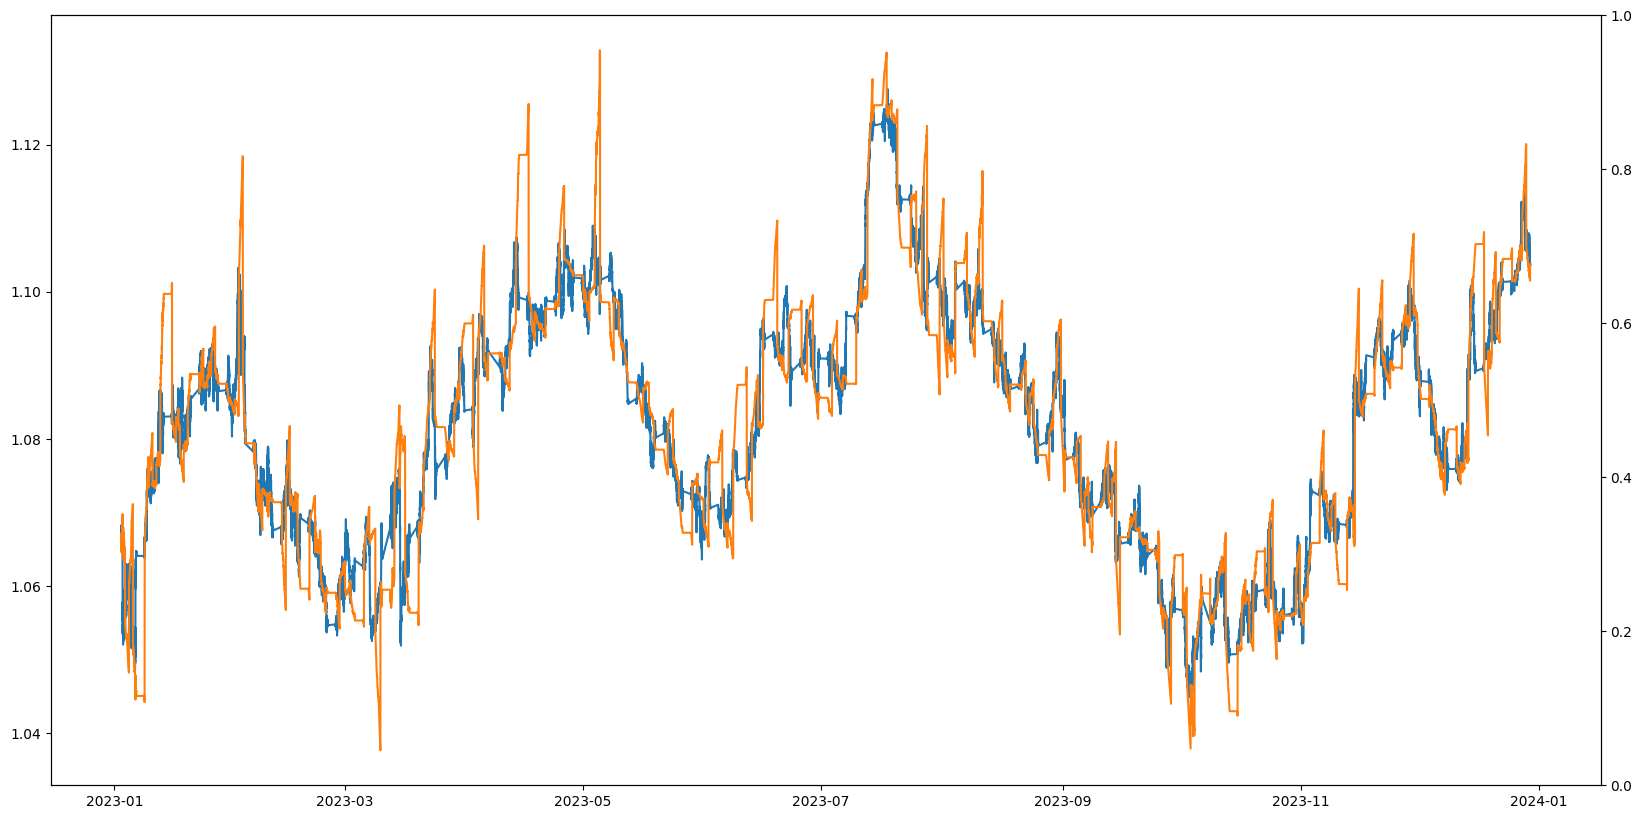

In [165]:
fig, ax  = plt.subplots(figsize = (20,10))
ax.plot(trade_df["Close"])
ax.plot(trade_df["spot_pred"])
ax1 = ax.twinx()
# ax1.plot(trade_df["y_pred"], color = "grey", alpha = 0.4)

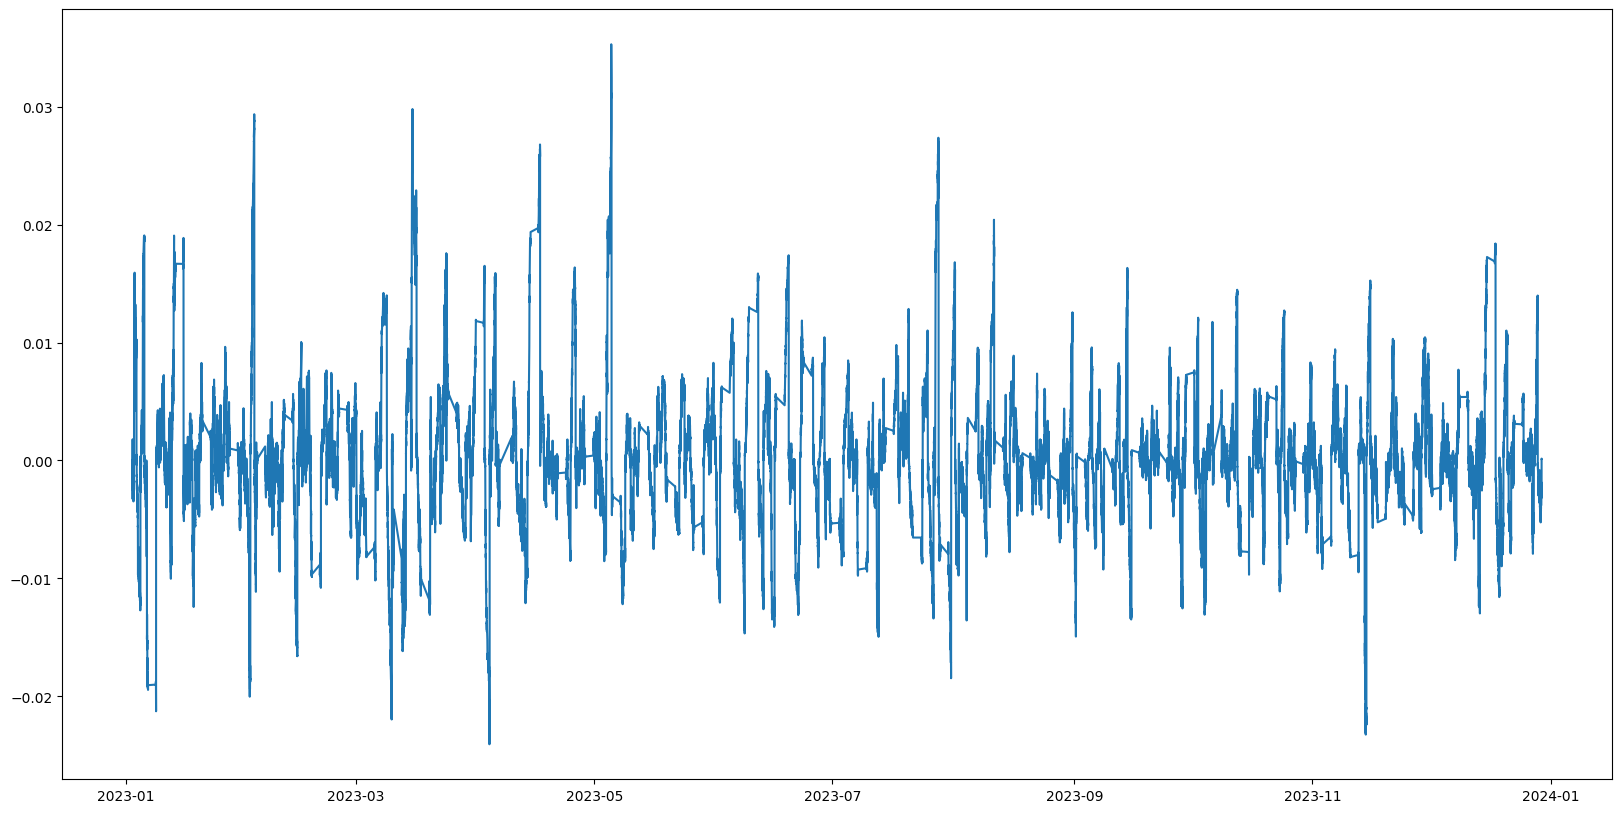

In [175]:
fig, ax  = plt.subplots(figsize = (20,10))
ax.plot(trade_df["spot_pred"] - trade_df["Close"])

In [176]:
# trade_df["pos"] = (trade_df["Close"] > trade_df["spot_pred"]).astype(int).replace(0, -1)
threshold = 0.01
trade_df["pos"] = np.where(trade_df["Close"]-trade_df["spot_pred"]<-threshold,1,np.where(trade_df["Close"]-trade_df["spot_pred"]>threshold,-1,0))

In [178]:
trade_df.head(10)

,Close,y_true,y_pred,spot_pred,pos,pct_change,strat_pct,buy_hold,strat_cum
DateTime,,,,,,,,,
2023-01-02 17:49:00,1.06637,-0.00004,3.131976e-07,1.066380,0,NaN,NaN,NaN,NaN
2023-01-02 17:50:00,1.06633,0.00000,4.884283e-06,1.066385,0,-0.000038,-0.0,0.999962,1.0
2023-01-02 17:53:00,1.06633,0.00004,5.333195e-06,1.066391,0,0.000000,0.0,0.999962,1.0
2023-01-02 17:54:00,1.06637,0.00001,-1.100132e-06,1.066389,0,0.000038,0.0,1.000000,1.0
2023-01-02 17:55:00,1.06638,-0.00005,-5.356115e-06,1.066384,0,0.000009,0.0,1.000009,1.0
2023-01-02 17:56:00,1.06633,0.00002,-3.847477e-07,1.066384,0,-0.000047,-0.0,0.999962,1.0
2023-01-02 17:57:00,1.06635,-0.00001,-1.829609e-06,1.066382,0,0.000019,0.0,0.999981,1.0
2023-01-02 17:58:00,1.06634,0.00000,-1.541386e-06,1.066380,0,-0.000009,-0.0,0.999972,1.0
2023-01-02 17:59:00,1.06634,0.00080,-1.968302e-06,1.066378,0,0.000000,0.0,0.999972,1.0


In [179]:
trade_df["pct_change"] = trade_df["Close"].pct_change()

In [180]:
trade_df["strat_pct"] = trade_df["pct_change"] * trade_df["pos"].shift(1)

In [181]:
trade_df["buy_hold"] = (trade_df["pct_change"]+1).cumprod()
trade_df["strat_cum"] = (trade_df["strat_pct"]+1).cumprod()


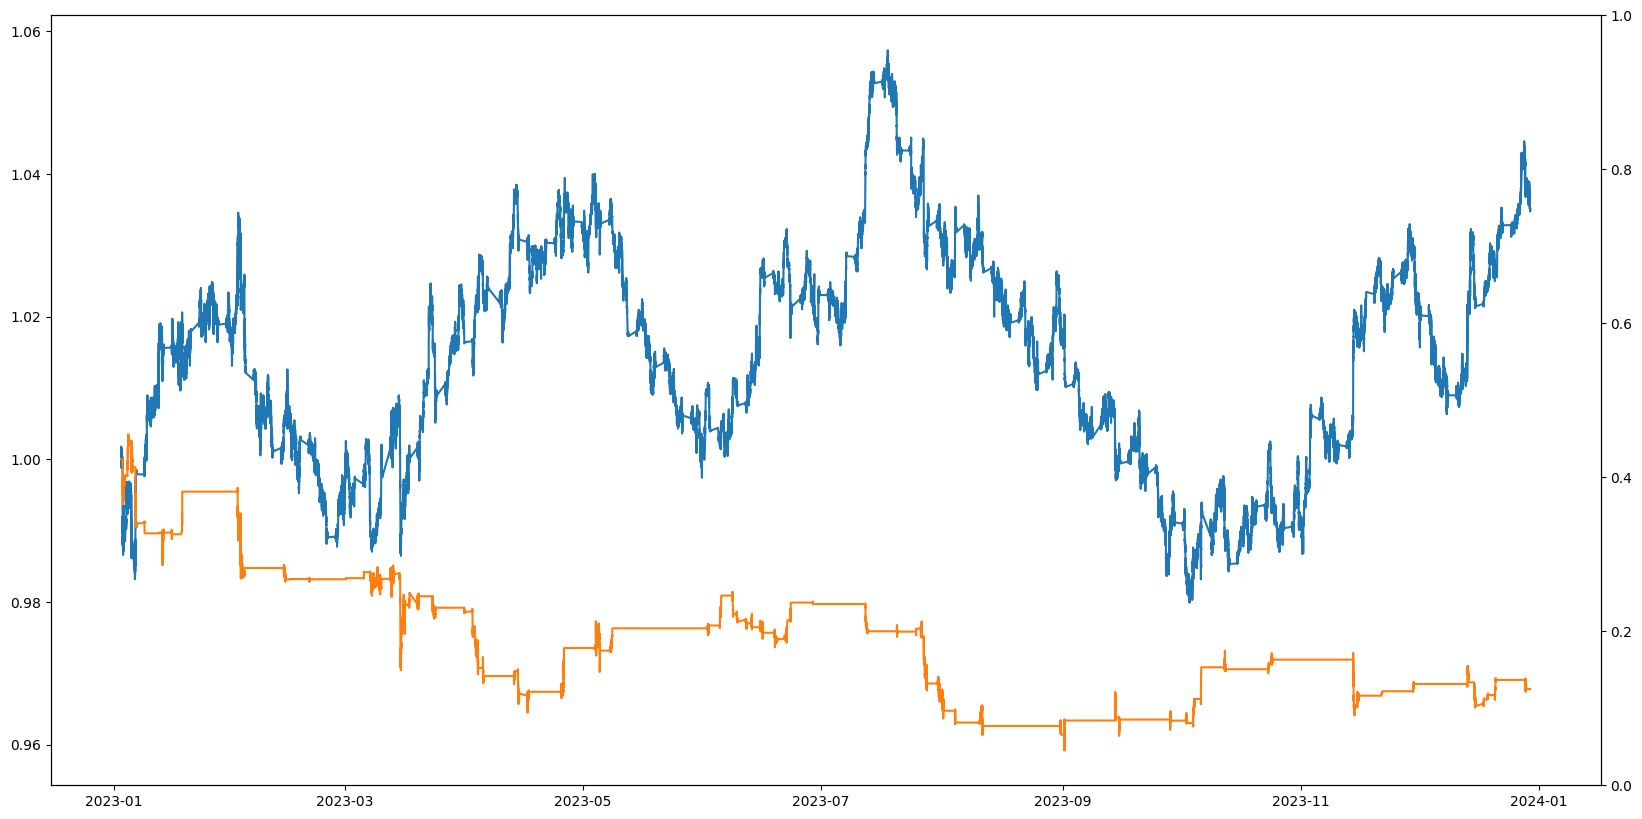

In [182]:
fig, ax  = plt.subplots(figsize = (20,10))
ax.plot(trade_df["buy_hold"])
ax.plot(trade_df["strat_cum"])
ax1 = ax.twinx()

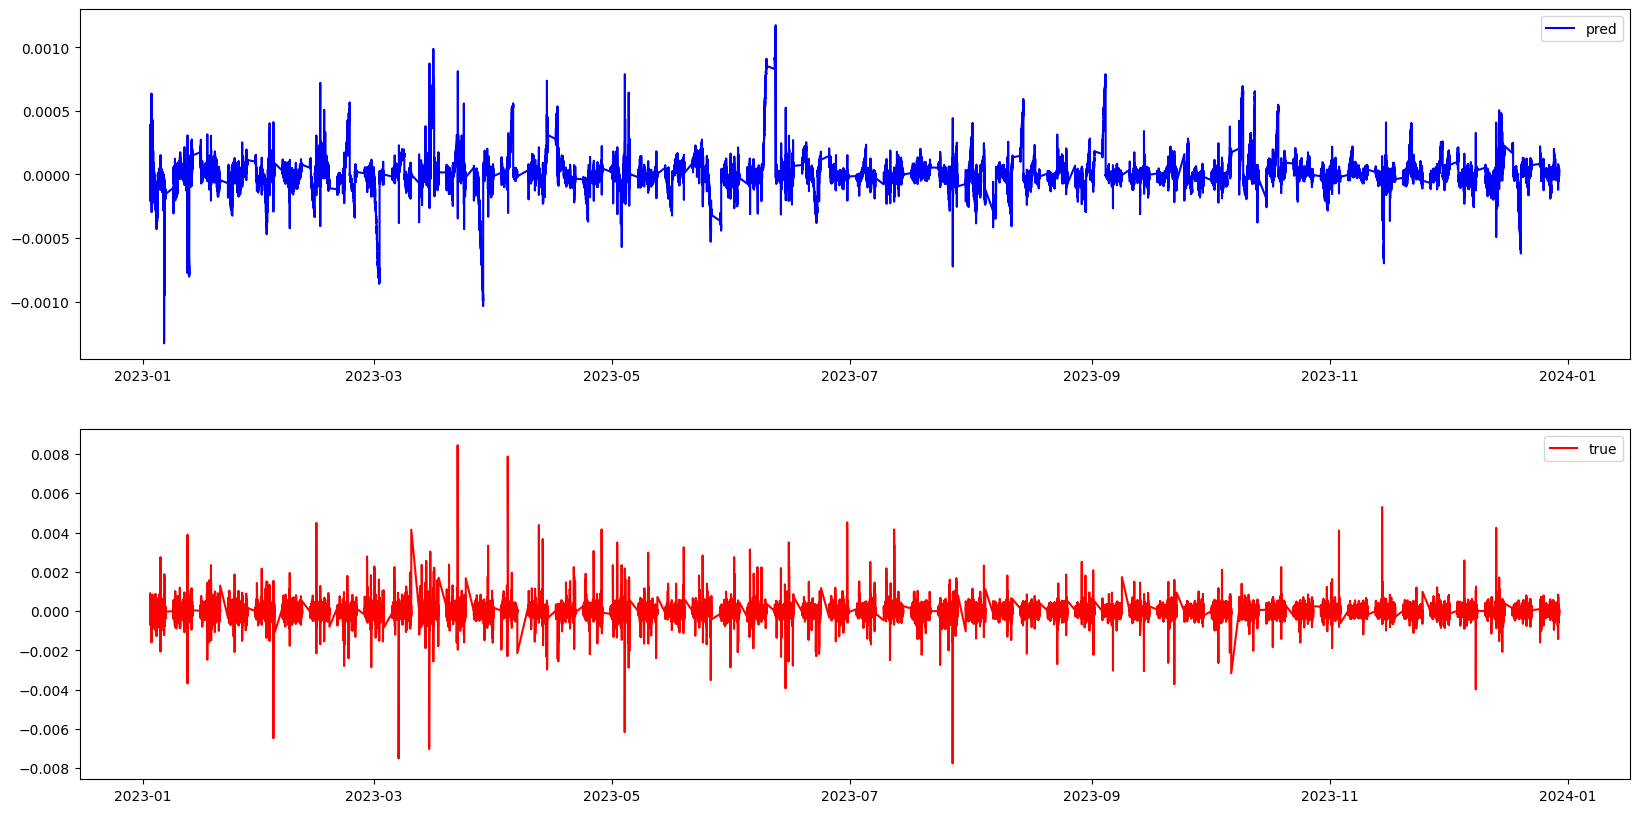

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(results_df.iloc[:,1], label = "pred", color = "blue")
ax[1].plot(results_df.iloc[:,0], label = "true", color = "red")
ax[0].legend()
ax[1].legend()
